# Simulation vs Observational Data of Shallow Cumulus Clouds over the Southern Great Plains on April 4th, 2019

## Import

In [41]:
# Lasso Simulation Data

# import dask
from datetime import datetime
from distributed import Client
import numpy as np
import xarray as xr
import xwrf
import s3fs
import fsspec
import xarray as xr
import glob

import matplotlib.pyplot as plt

## Spin up a Dask Cluster
We will use Dask here to access the data in a parallel/distributed manner.

In [43]:
client = Client()
client

/Users/mgrover/mambaforge/envs/lasso-those-clouds-cookbook-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65202 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:65202/status,
Dashboard: http://127.0.0.1:65202/status,Workers: 5
Total threads: 10,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65203,Workers: 5
Dashboard: http://127.0.0.1:65202/status,Total threads: 10
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:65216,Total threads: 2
Dashboard: http://127.0.0.1:65218/status,Memory: 6.40 GiB
Nanny: tcp://127.0.0.1:65206,


## Access LASSO SGP Data from the NSF Jetstream Cloud
A subset of the LASSO Shallow Cumulus Experiment over the Southern Great Plains site has been made available on a cloud bucket, hosted through Project Pythia. These datasets were originally accessed through the [LASSO bundle browser](https://adc.arm.gov/lassobrowser), untarred, then uploaded to the cloud bucket. We focus exclusively on the April 4, 2019 case.

Data were obtained from the Atmospheric Radiation Measurement (ARM) Program sponsored by the U.S. Department of Energy, Office of Science, Office of Biological and Environmental Research, Climate and Environmental Sciences Division.

### Set the URL to access the data
The data are stored on a bucket, which is a web-accessible place where we can remotely **stream** the data, without downloading directly. The bucket is located on the NSF jetstream cloud, which we can see below. We then use `fsspec` to easily list the directrories and load in the data.

Below we set the url, then list (glob) the directories in the bucket.

In [12]:
# Set the URL and path for the cloud
URL = 'https://js2.jetstream-cloud.org:8001/'
path = f'pythia/lasso-sgp'


fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))

fs.glob(f"{path}/*")

['pythia/lasso-sgp/high_res_obs',
 'pythia/lasso-sgp/metrics',
 'pythia/lasso-sgp/sim0001',
 'pythia/lasso-sgp/sim0002',
 'pythia/lasso-sgp/sim0003',
 'pythia/lasso-sgp/sim0004',
 'pythia/lasso-sgp/sim0005',
 'pythia/lasso-sgp/sim0006',
 'pythia/lasso-sgp/sim0007',
 'pythia/lasso-sgp/sim0008']

We notice that there are 8 simulations, as well as observations in the bucket. We are going to start with the fourth simulation, setting a path to the actual output, which is under `/raw_model/`

In [29]:
case_date = datetime(2019, 4, 4)
sim_id = 4

# Read the wrfstat files
wrfstat_pattern = f's3://{path}/sim000{sim_id}/raw_model/wrfstat*'

# Read the wrfout files
wrfout_pattern = f's3://{path}/sim000{sim_id}/raw_model/wrfout*'

wrfstat_files = sorted(fs.glob(wrfstat_pattern))
wrfout_files = sorted(fs.glob(wrfout_pattern))

Now that we have lists of files, we setup a path to read into xarray since we need the bucket information as well.

In [39]:
wrfstat_file_list = [fs.open(file) for file in wrfstat_files]
wrfout_file_list = [fs.open(file) for file in wrfout_files]

### Load Data Using Xarray and View Variables

We have a single WRF stat file, which we can load into xarray, then postprocess with xwrf.

In [38]:
ds_stat = xr.open_mfdataset(wrfstat_file_list, engine='h5netcdf').xwrf.postprocess()
ds_stat

<xarray.Dataset> Size: 72GB
Dimensions:         (Time: 91, z: 226, z_stag: 227, y: 250, x: 250,
                     x_stag: 251, y_stag: 251)
Coordinates:
    XTIME           (Time) datetime64[ns] 728B dask.array<chunksize=(91,), meta=np.ndarray>
  * Time            (Time) datetime64[ns] 728B 2019-04-04T12:00:00 ... 2019-0...
  * x_stag          (x_stag) float64 2kB -1.25e+04 -1.24e+04 ... 1.25e+04
  * x               (x) float64 2kB -1.245e+04 -1.235e+04 ... 1.245e+04
  * y               (y) float64 2kB -1.245e+04 -1.235e+04 ... 1.245e+04
  * y_stag          (y_stag) float64 2kB -1.25e+04 -1.24e+04 ... 1.25e+04
Dimensions without coordinates: z, z_stag
Data variables: (12/179)
    Times           (Time) |S19 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    CST_CLDLOW      (Time) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    CST_CLDTOT      (Time) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    CST_LWP         (Time) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    CST_IWP         (Time) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    CST_PRECW       (Time) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    ...              ...
    CSV_IWC         (Time, z, y, x) float32 5GB dask.array<chunksize=(1, 226, 125, 125), meta=np.ndarray>
    CSV_CLDFRAC     (Time, z, y, x) float32 5GB dask.array<chunksize=(1, 226, 125, 125), meta=np.ndarray>
    CSS_LWP         (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    CSS_IWP         (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    CSS_CLDTOT      (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    CSS_CLDLOW      (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
Attributes: (12/96)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-04-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20190404v1addhm
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov

In [2]:
# Plotting wrfstat variables...

# path_shcu_root = "/gpfs/wolf2/arm/atm124/world-shared/arm-summer-school-2024/lasso_tutorial/ShCu/untar/"  # on cumulus
path_shcu_root = "/data/project/ARM_Summer_School_2024_Data/lasso_tutorial/ShCu/untar"  # on Jupyter

case_date = datetime(2019, 4, 4)
sim_id = 4

ds_stat = xr.open_dataset(f"{path_shcu_root}/{case_date:%Y%m%d}/sim{sim_id:04d}/raw_model/wrfstat_d01_{case_date:%Y-%m-%d_12:00:00}.nc")
ds_stat

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


<xarray.Dataset> Size: 72GB
Dimensions:         (Time: 91, bottom_top: 226, bottom_top_stag: 227,
                     south_north: 250, west_east: 250, west_east_stag: 251,
                     south_north_stag: 251)
Coordinates:
    XTIME           (Time) datetime64[ns] 728B ...
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, south_north,
                                west_east, west_east_stag, south_north_stag
Data variables: (12/179)
    Times           (Time) |S19 2kB ...
    CST_CLDLOW      (Time) float32 364B ...
    CST_CLDTOT      (Time) float32 364B ...
    CST_LWP         (Time) float32 364B ...
    CST_IWP         (Time) float32 364B ...
    CST_PRECW       (Time) float32 364B ...
    ...              ...
    CSV_IWC         (Time, bottom_top, south_north, west_east) float32 5GB ...
    CSV_CLDFRAC     (Time, bottom_top, south_north, west_east) float32 5GB ...
    CSS_LWP         (Time, south_north, west_east) float32 23MB ...
    CSS_IWP         (Time, south_north, west_east) float32 23MB ...
    CSS_CLDTOT      (Time, south_north, west_east) float32 23MB ...
    CSS_CLDLOW      (Time, south_north, west_east) float32 23MB ...
Attributes: (12/96)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-04-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20190404v1addhm
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov

## Plot Variables and Modify as Desired

xwrf automatically corrected the time for us! So now we can focus on subsetting given an hour. In this case, we are interested in `1700 UTC`.

In [25]:
ds_stat.CSV_LWC

<xarray.DataArray 'CSV_LWC' (Time: 91, z: 226, y: 250, x: 250)> Size: 5GB
[1285375000 values with dtype=float32]
Coordinates:
    XTIME    (Time) datetime64[ns] 728B ...
  * Time     (Time) datetime64[ns] 728B 2019-04-04T12:00:00 ... 2019-04-05T03...
  * x        (x) float64 2kB -1.245e+04 -1.235e+04 ... 1.235e+04 1.245e+04
  * y        (y) float64 2kB -1.245e+04 -1.235e+04 ... 1.235e+04 1.245e+04
Dimensions without coordinates: z
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  Time-averaged liquid water content (based on ql)
    units:        kg/m^3
    stagger:

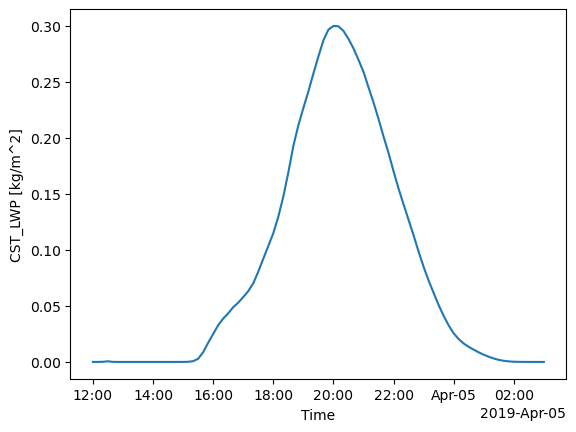

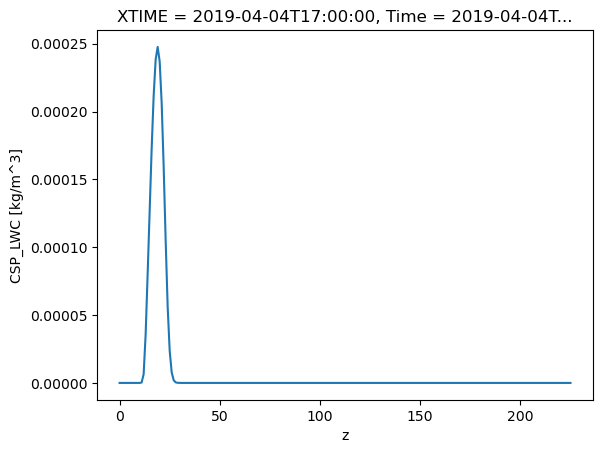

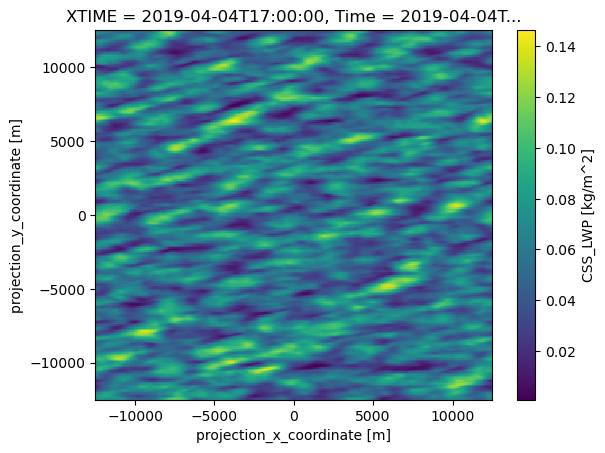

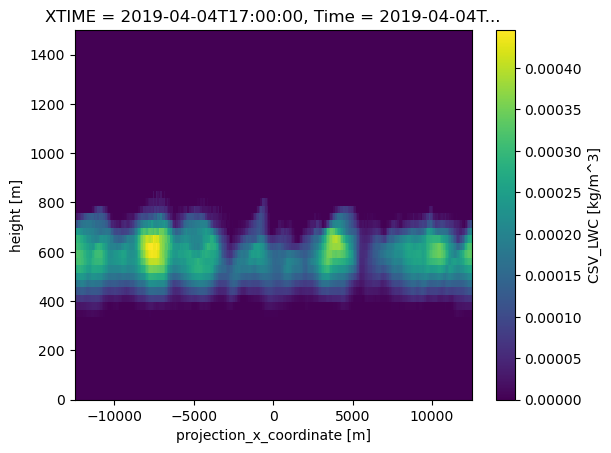

In [27]:
hour_to_plot = 17

# Time series:
ds_stat["CST_LWP"].plot()
plt.show()

# Profile at a selected time (plots sideways, though, since we are being lazy):
ds_stat["CSP_LWC"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00").plot()
plt.show()

# X-Y slice for a selected time:
ds_stat["CSS_LWP"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00").plot()
plt.show()

# A vertical slice from the volume at a selected time:
# We'll assign the vertical coordinate values for this one and hide the cloud-free upper atmosphere.
plot_data = ds_stat["CSV_LWC"].assign_coords(height=(ds_stat["CSP_Z"]))
plot_data.sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00", y=-12450).plot(y="height", ylim=[0, 1500])
plt.show()

# Add lines and modify variables to plot desired figures... In this notebook, we plotted 

# Plot wind speed 
Let's start with the first 10 files from the WRF simulation.

In [75]:
# Note the extra details required by open_mfdataset to connect the files together in time.
ds_wrf = xr.open_mfdataset(wrfout_file_list[:10],
                           combine="nested",
                           concat_dim="Time")

Since we did not use xwrf, this time, let's fix the times.

In [85]:
ds_wrf["Time"] = ds_wrf["XTIME"]

/Users/mgrover/mambaforge/envs/lasso-those-clouds-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 50.03 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-06-14 11:17:32,730 - distributed.nanny - ERROR - Worker process died unexpectedly


## Visualize the Wind Vectors and Expose Destaggering
Next, we plot wind vectors at a selected level to demonstrate how to destagger the wind components to cell-center values with xarray. The destaggering is something that we can automatically handle with xwrf, but we explain the process below to be more transparent, especially with winds that are not in the cell-centers.

### Destagger and Rename Dimensions

We need to:
1) destagger to cell centers
2) rename the staggered dimension back to the non-staggered name to avoid dimension conflicts
3) (re)name the unstaggered wind for convenience
4) Then, we are able to put these new DataArrays back into the ds_wrf Dataset.

In [76]:
# Plot wind vectors at a selected level to demonstrate how to destagger the wind components to cell-center values with xarray...

plot_level = 12  # index of level to plot
skip_xy = 10  # Sampling interval for the vector thinning

nt, nz, ny, nx = ds_wrf["T"].shape

ds_wrf["UA"] = 0.5*( ds_wrf["U"].isel(west_east_stag=slice(0, nx)) + 
                    ds_wrf["U"].shift(west_east_stag=-1).isel(west_east_stag=slice(0, nx)) ).\
                    rename("UA").rename(west_east_stag="west_east")
ds_wrf["VA"] = 0.5*( ds_wrf["V"].isel(south_north_stag=slice(0, ny)) + 
                    ds_wrf["V"].shift(south_north_stag=-1).isel(south_north_stag=slice(0, ny)) ).\
                    rename("VA").rename(south_north_stag="south_north")
ds_wrf["SPD"] = np.sqrt(ds_wrf["UA"]**2 + ds_wrf["VA"]**2).rename("wind speed").\
                    assign_attrs(units="m s-1", description="wind speed")

### Visualize the Speed and Wind Vectors

Now, we can proceed to more plotting-specific data manipulation. We need to add spatial variables for the idealized domain (since XLAT and XLONG are constant in the file). This is needed by the xarray quiver routine.

Then, thin the grid to reduce the number of arrrows.

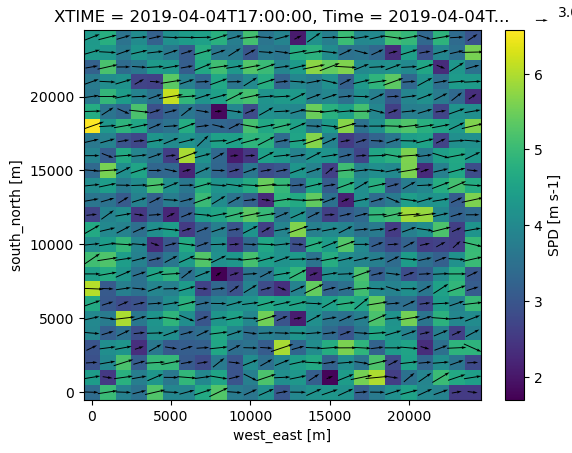

In [87]:
ds_wrf["west_east"] = xr.DataArray(data=np.arange(nx)*ds_wrf.attrs["DX"], dims="west_east", name="west_east", attrs={"units": "m"})
ds_wrf["south_north"] = xr.DataArray(data=np.arange(ny)*ds_wrf.attrs["DX"], dims="south_north", name="south_north", attrs={"units": "m"})

ds_wrf_thinned = ds_wrf.\
    isel(west_east=slice(0, nx, skip_xy), south_north=slice(0, ny, skip_xy), bottom_top=plot_level).\
    sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00")

fig, ax = plt.subplots(ncols=1)
ds_wrf_thinned["SPD"].plot(ax=ax, x="west_east", y="south_north")
ds_wrf_thinned.plot.quiver(ax=ax, x="west_east", y="south_north", u="UA", v="VA",
                           scale=100)
plt.show()

## Compare with Observational Data from ARM

Now that we have plotted the simulation data from WRF, let's take a look at the observations.

In [88]:
fs.glob(f"{path}/*")

['pythia/lasso-sgp/high_res_obs',
 'pythia/lasso-sgp/metrics',
 'pythia/lasso-sgp/sim0001',
 'pythia/lasso-sgp/sim0002',
 'pythia/lasso-sgp/sim0003',
 'pythia/lasso-sgp/sim0004',
 'pythia/lasso-sgp/sim0005',
 'pythia/lasso-sgp/sim0006',
 'pythia/lasso-sgp/sim0007',
 'pythia/lasso-sgp/sim0008']

In [90]:
fs.glob('pythia/lasso-sgp/high_res_obs/sgp*')

['pythia/lasso-sgp/high_res_obs/sgp915rwpwindcon10mC1.c1',
 'pythia/lasso-sgp/high_res_obs/sgp915rwpwindcon10mI10.c1',
 'pythia/lasso-sgp/high_res_obs/sgp915rwpwindcon10mI8.c1',
 'pythia/lasso-sgp/high_res_obs/sgp915rwpwindcon10mI9.c1',
 'pythia/lasso-sgp/high_res_obs/sgpcldfraccogs01mC1.c1',
 'pythia/lasso-sgp/high_res_obs/sgpcldfraccogs10mC1.c1',
 'pythia/lasso-sgp/high_res_obs/sgpcldfracset01mC1.c1',
 'pythia/lasso-sgp/high_res_obs/sgpcldfracset05mC1.c1',
 'pythia/lasso-sgp/high_res_obs/sgpcldfracset15mC1.c1',
 'pythia/lasso-sgp/high_res_obs/sgplassoblthermoC1.c1',
 'pythia/lasso-sgp/high_res_obs/sgplassodlcbhshcuC1.c1',
 'pythia/lasso-sgp/high_res_obs/sgplassodlcbhshcuE32.c1',
 'pythia/lasso-sgp/high_res_obs/sgplassodlcbhshcuE37.c1',
 'pythia/lasso-sgp/high_res_obs/sgplassodlcbhshcuE39.c1',
 'pythia/lasso-sgp/high_res_obs/sgplassodlcbhshcuE41.c1',
 'pythia/lasso-sgp/high_res_obs/sgplassolwpC1.c1',
 'pythia/lasso-sgp/high_res_obs/sgplclC1.c1']

/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


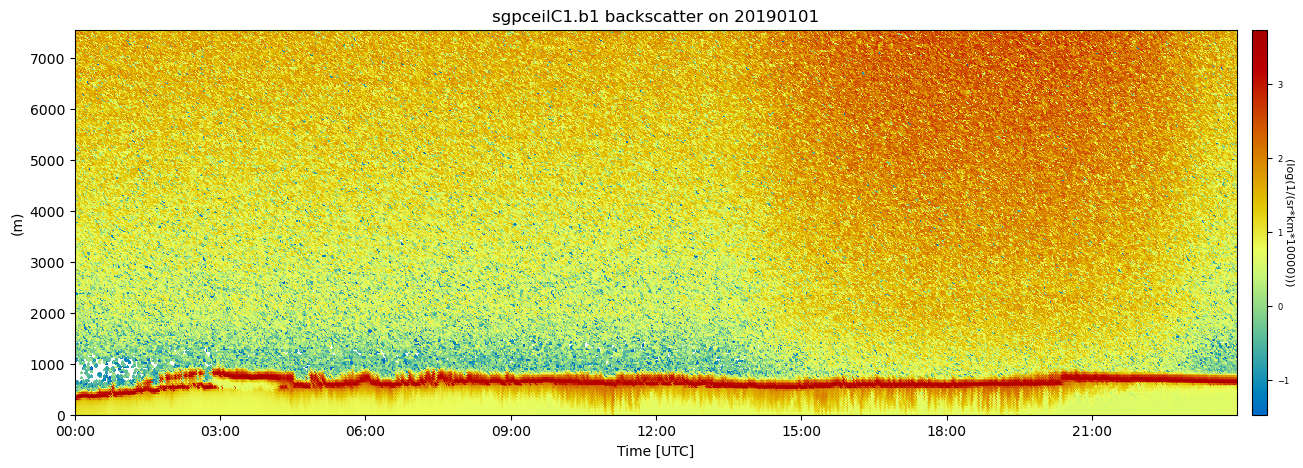

In [7]:
# Compare with ARM Observational Data

import os

from arm_test_data import DATASETS
import matplotlib.pyplot as plt

import act

# Place your username and token here
username = os.getenv('ARM_USERNAME')
token = os.getenv('ARM_PASSWORD')

# If the username and token are not set, use the existing sample file
if username is None or token is None or len(username) == 0 or len(token) == 0:
    filename_ceil = DATASETS.fetch('sgpceilC1.b1.20190101.000000.nc')
    ceil_ds = act.io.arm.read_arm_netcdf(filename_ceil, engine='netcdf4')
else:
    # Example to show how easy it is to download ARM data if a username/token are set
    results = act.discovery.download_arm_data(
        username, token, 'sgpceilC1.b1', '2022-01-14', '2022-01-19'
    )
    ceil_ds = act.io.arm.read_arm_netcdf(results)

# Adjust ceilometer data for plotting
ceil_ds = act.corrections.ceil.correct_ceil(ceil_ds, -9999.0)

# Plot up ceilometer backscatter using HomeyerRainbow CVD friendly colormap
# The same could be done with keyword 'cmap='HomeyerRainbow'
display = act.plotting.TimeSeriesDisplay(ceil_ds, subplot_shape=(1,), figsize=(15, 5))
display.plot('backscatter', subplot_index=(0,), cvd_friendly=True)
plt.show()

In [7]:
# ARM Plotting v2
import act
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Plot Desired Variables

In [8]:
# Set your username and token here!
username = '***'
token = '***'

# Set the datastream and start/enddates
datastream = 'sgpaosmetE13.a1'
startdate = '2019-04-04'
enddate = '2019-04-05'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

[DOWNLOADING] sgpaosmetE13.a1.20190404.000000.nc

If you use these data to prepare a publication, please cite:

Kyrouac, J., Springston, S., & Tuftedal, M. Meteorological Measurements
associated with the Aerosol Observing System (AOSMET). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1984920



In [9]:
# Let's read in the data using ACT and check out the data
ds_mpl = act.io.read_arm_netcdf(result)

ds_mpl

<xarray.Dataset> Size: 6MB
Dimensions:              (time: 86399)
Coordinates:
  * time                 (time) datetime64[ns] 691kB 2019-04-04T00:00:00.2200...
Data variables: (12/17)
    base_time            datetime64[ns] 8B 2019-04-04
    time_offset          (time) datetime64[ns] 691kB 2019-04-04T00:00:00.2200...
    rh_ambient           (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    temperature_ambient  (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    pressure_ambient     (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    wind_speed           (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    ...                   ...
    heater_volts         (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    supply_volts         (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    ref_volts            (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    lat                  float32 4B ...
    lon                  float32 4B ...
    alt                  float32 4B ...
Attributes: (12/23)
    command_line:                aosmet_ingest -s sgp -f E13
    Conventions:                 ARM-1.2
    process_version:             ingest-aosmet-1.0-0.el6
    dod_version:                 aosmet-a1-2.2
    input_source:                /data/collection/sgp/sgpaosmetE13.00/sgpaosE...
    site_id:                     sgp
    ...                          ...
    doi:                         10.5439/1325987
    history:                     created by user dsmgr on machine ruby at 201...
    _file_dates:                 ['20190404']
    _file_times:                 ['000000']
    _datastream:                 sgpaosmetE13.a1
    _arm_standards_flag:         1

# Change variable (as desired), Apply QC, and Plot Again

<Axes: title={'center': 'sgpaosmetE13.a1 temperature_ambient on 20190404'}, xlabel='Time [UTC]', ylabel='(degC)'>

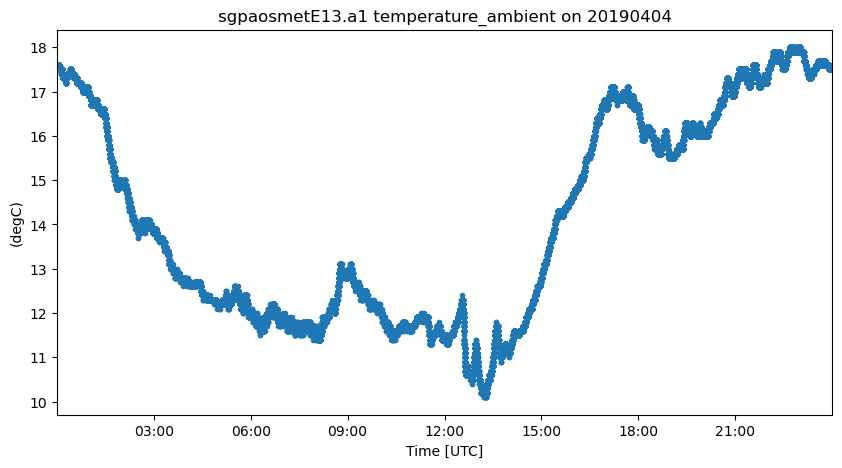

In [10]:
# Let's take a look at the quality control information associated with a variable from the MPL
variable = 'temperature_ambient'

# First, for many of the ACT QC features, we need to get the dataset more to CF standard and that
# involves cleaning up some of the attributes and ways that ARM has historically handled QC
ds_mpl.clean.cleanup()

# Apply corrections for the ceilometer, correcting for the vertical height
#ds_mpl = act.corrections.ceil.correct_ceil(ds_mpl,-999.0)

# Next, let's take a look at visualizing the quality control information
# Create a plotting display object with 2 plots
display = act.plotting.TimeSeriesDisplay(ds_mpl, figsize=(10, 5), subplot_shape=(1,))

# # Plot up the variable in the first plot
display.plot(variable, subplot_index=(0,))

# # Plot up the QC variable in the second plot
# #display.qc_flag_block_plot(variable, subplot_index=(1,))
# plt.show()